In [ ]:
%pip install -U \
    openai \
    azure-ai-projects \
    azure-monitor-opentelemetry \
    opentelemetry-instrumentation-openai-v2 \
    mcp \
    anyio \
    sounddevice

In [16]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI, OpenAI

NEXTGEN_API_TYPE: bool = True

def print_responses_output(responses: object) -> None:
    print("=== Responses Output ===")
    print(f"🧾 ID: {responses.id}")
    print(f"🧾 Model: {responses.model}")
    print(f"🧾 Status: {responses.status}")
    print(f"🧾 Usage: {responses.usage}")
    for output in responses.output:
        if output.type == "reasoning":
            print(f"🤔 Reasoning: {output.summary}")
        elif output.type == "message":
            for content in output.content:
                if content.type == "output_text":
                    print(f"💬 Message|OutputText: {content.text}")
    print("========================")

# notebook 환경변수를 위해 .env 파일을 로드합니다.
load_dotenv(dotenv_path=".env", override=True)

# OpenAI 의 Azure 클라이언트를 생성합니다.
if NEXTGEN_API_TYPE:
    client = OpenAI(
        api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        base_url=os.getenv("AZURE_OPENAI_ENDPOINT") + "openai/v1/",
        default_query={"api-version": "preview"},
    )
else:
    client = AzureOpenAI(
        api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    )

# GPT-5 OpenAI 의 Azure 클라이언트를 생성합니다.
if NEXTGEN_API_TYPE:
    gpt5_client = OpenAI(
        api_key=os.getenv("AZURE_OPENAI_GPT5_API_KEY"),
        base_url=os.getenv("AZURE_OPENAI_GPT5_ENDPOINT") + "openai/v1/",
        default_query={"api-version": "preview"},
    )
else:
    gpt5_client = AzureOpenAI(
        api_version=os.getenv("AZURE_OPENAI_GPT5_API_VERSION"),
        azure_endpoint=os.getenv("AZURE_OPENAI_GPT5_ENDPOINT"),
        api_key=os.getenv("AZURE_OPENAI_GPT5_API_KEY"),
    )


In [3]:
# input/output message content를 캡처하기 위해 환경변수를 설정합니다.
import os

os.environ["OTEL_INSTRUMENTATION_GENAI_CAPTURE_MESSAGE_CONTENT"] = "true"
os.environ["AZURE_TRACING_GEN_AI_CONTENT_RECORDING_ENABLED"] = "true"

# from azure.ai.projects import AIProjectClient
from azure.monitor.opentelemetry import configure_azure_monitor
from opentelemetry.instrumentation.openai_v2 import OpenAIInstrumentor
from azure.ai.projects import AIProjectClient
from azure.identity import AzureCliCredential

# OpenAI API 호출을 자동으로 계측하기 위해 OpenAIInstrumentor를 사용합니다.
OpenAIInstrumentor().instrument()

# AIProjectClient를 사용하여 Azure AI Foundry 프로젝트에 연결합니다.
# API Key를 TokenCredential로 변환합니다.
project_client = AIProjectClient(
    credential=AzureCliCredential(),
    endpoint=os.getenv("AZURE_AI_FOUNDRY_PROJECT_ENDPOINT"),
)
# Azure Monitor를 구성합니다.
configure_azure_monitor(connection_string=project_client.telemetry.get_application_insights_connection_string())

# QuickStart

## Chat Completions

In [5]:
import os

# chat completions API 를 통해 Q&A 를 수행합니다.
response = client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    messages=[{"role": "user", "content": "안녕. 만나서 반가워. 너는 누구야 ?"}],
)

print(response.choices[0].message.content)

안녕하세요! 만나서 반가워요. 저는 OpenAI에서 개발한 인공지능 언어 모델인 ChatGPT예요. 궁금한 점이나 도움이 필요한 것이 있으면 언제든지 말씀해 주세요. 어떻게 도와드릴까요?


## Responses

In [6]:
from openai.types.responses import EasyInputMessageParam

user_input = "안녕. 만나서 반가워. 나랑 끝말잊기 게임하자."
while True:
    # chat/completions API 호출; 응답이 server-side 에 저장되지 않는다.
    response = gpt5_client.chat.completions.create(
        model=os.getenv("AZURE_OPENAI_GPT5_DEPLOYMENT_NAME"),
        messages=[
            EasyInputMessageParam(
                role="system", 
                content=(
                    "너는 끝말잊기 게임봇이야."
                    "너는 사용자와 끝말잊기 게임을 하는데, 사용자가 말한 단어의 마지막 글자를 따서 다음 단어를 말해야 해."
                    "응답할때는 그동안 끝말 이은 단어를 모두 써줘."
                ),
            ),
            EasyInputMessageParam(
                role="user",
                content=user_input,
            ),
        ],
    )
    print("--------------------------------")
    print(f"🤖 {response.choices[0].message.content}", flush=True)
    user_input = input()
    print("--------------------------------")
    print(f"👱🏻 {user_input}", flush=True)
    if not user_input or user_input.lower() == "exit":
        break

/opt/anaconda3/envs/azure-dev/lib/python3.12/site-packages/opentelemetry/sdk/_events/__init__.py:53: LogDeprecatedInitWarning: LogRecord init with `trace_id`, `span_id`, and/or `trace_flags` is deprecated since 1.35.0. Use `context` instead.
  log_record = LogRecord(


--------------------------------
🤖 좋아! 내가 먼저 시작할게.

지금까지 이은 단어: 사과
다음 단어는 ‘과’로 시작해야 해. 너 차례!
--------------------------------
👱🏻 과일
--------------------------------
🤖 과일 → 일기

이제 ‘기’로 시작하는 단어로 이어 주세요!
--------------------------------
👱🏻 기록
--------------------------------
🤖 기록 -> 록밴드
--------------------------------
👱🏻 exit


In [8]:
from openai.types.responses import EasyInputMessageParam

user_input = "안녕. 만나서 반가워. 나랑 끝말잊기 게임하자."
previous_response_id = None
while True:
    # responses API 를 이용; chain-of-response 로 이전 응답이 server-side 에 저장된다.
    response = gpt5_client.responses.create(
        previous_response_id=previous_response_id,
        model=os.getenv("AZURE_OPENAI_GPT5_DEPLOYMENT_NAME"),
        input=[
            EasyInputMessageParam(
                role="system", 
                content=(
                    "너는 끝말잊기 게임봇이야."
                    "너는 사용자와 끝말잊기 게임을 하는데, 사용자가 말한 단어의 마지막 글자를 따서 다음 단어를 말해야 해."
                    "응답할때는 그동안 끝말 이은 단어를 모두 써줘."
                ),
            ),
            EasyInputMessageParam(
                role="user",
                content=user_input,
            ),
        ],
    )
    print("--------------------------------")
    print(f"🤖 {response.output[1].content[0].text}", flush=True)
    user_input = input()
    print("--------------------------------")
    print(f"👱🏻 {user_input}", flush=True)
    if not user_input or user_input.lower() == "exit":
        break
    previous_response_id = response.id

--------------------------------
🤖 좋아! 끝말잇기 시작하자. 네가 먼저 단어를 말해줘.
- 현재까지 이어진 단어: (없음)
--------------------------------
👱🏻 기록
--------------------------------
🤖 내 단어: 록음악
- 현재까지 이어진 단어: 기록 → 록음악
다음 단어는 ‘악’으로 시작해줘!
--------------------------------
👱🏻 악수
--------------------------------
🤖 내 단어: 수박
- 현재까지 이어진 단어: 기록 → 록음악 → 악수 → 수박
다음 단어는 ‘박’으로 시작해줘!
--------------------------------
👱🏻 박수
--------------------------------
🤖 내 단어: 수학
- 현재까지 이어진 단어: 기록 → 록음악 → 악수 → 수박 → 박수 → 수학
다음 단어는 ‘학’으로 시작해줘!
--------------------------------
👱🏻 exit


## Model Router


In [10]:
response = gpt5_client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_MODEL_ROUTER_DEPLOYMENT_NAME"),
    messages=[
        {
            "role": "user",
            "content": (
                "hi"
            )
        }
    ],
)
print(f"🤖 ({response.model}): {response.choices[0].message.content}")

/opt/anaconda3/envs/azure-dev/lib/python3.12/site-packages/opentelemetry/sdk/_events/__init__.py:53: LogDeprecatedInitWarning: LogRecord init with `trace_id`, `span_id`, and/or `trace_flags` is deprecated since 1.35.0. Use `context` instead.
  log_record = LogRecord(


🤖 (gpt-4.1-nano-2025-04-14): Hello! How can I assist you today?


In [11]:
response = gpt5_client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_MODEL_ROUTER_DEPLOYMENT_NAME"),
    messages=[
        {
            "role": "user",
            "content": (
                "최종답변이 글자 'M' 이 되는 5x5 nonogram 을 만들어줘."
            )
        }
    ],
)
print(f"🤖 ({response.model}): {response.choices[0].message.content}")

🤖 (gpt-5-mini-2025-08-07): 아래는 5×5 논그램으로, 정답 그림이 문자 'M'이 되도록 만든 문제입니다.

행 단서(위에서 아래로):
1. 1,1
2. 2,2
3. 1,1,1
4. 1,1
5. 1,1

열 단서(왼쪽에서 오른쪽으로):
1. 5
2. 1
3. 1
4. 1
5. 5

해답(참고용; X가 채워진 칸):
1. X . . . X
2. X X . X X
3. X . X . X
4. X . . . X
5. X . . . X

즐겁게 풀어보세요!


In [14]:
response = gpt5_client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_MODEL_ROUTER_DEPLOYMENT_NAME"),
    messages=[
        {
            "role": "user",
            "content": (
                "아래 단서를 근거로 5x5 nonogram 은 어떤 글자를 나타내는지 맞춰봐.\n"
                "행 단서(위에서 아래로):\n"
                "1. 1 1\n"
                "2. 2 2\n"
                "3. 1 1 1\n"
                "4. 1 1\n"
                "5. 1 1\n"
            )
        }
    ],
)
print(f"🤖 ({response.model}): {response.choices[0].message.content}")

🤖 (gpt-5-mini-2025-08-07): 다음과 같은 5x5 픽셀 패턴이 유일하게 들어맞습니다.

행별(위→아래)
1: 1 0 0 0 1  -> "1 1"
2: 1 1 0 1 1  -> "2 2"
3: 1 0 1 0 1  -> "1 1 1"
4: 1 0 0 0 1  -> "1 1"
5: 1 0 0 0 1  -> "1 1"

이 패턴은 알파벳 "M"을 나타냅니다.


## Image Generation

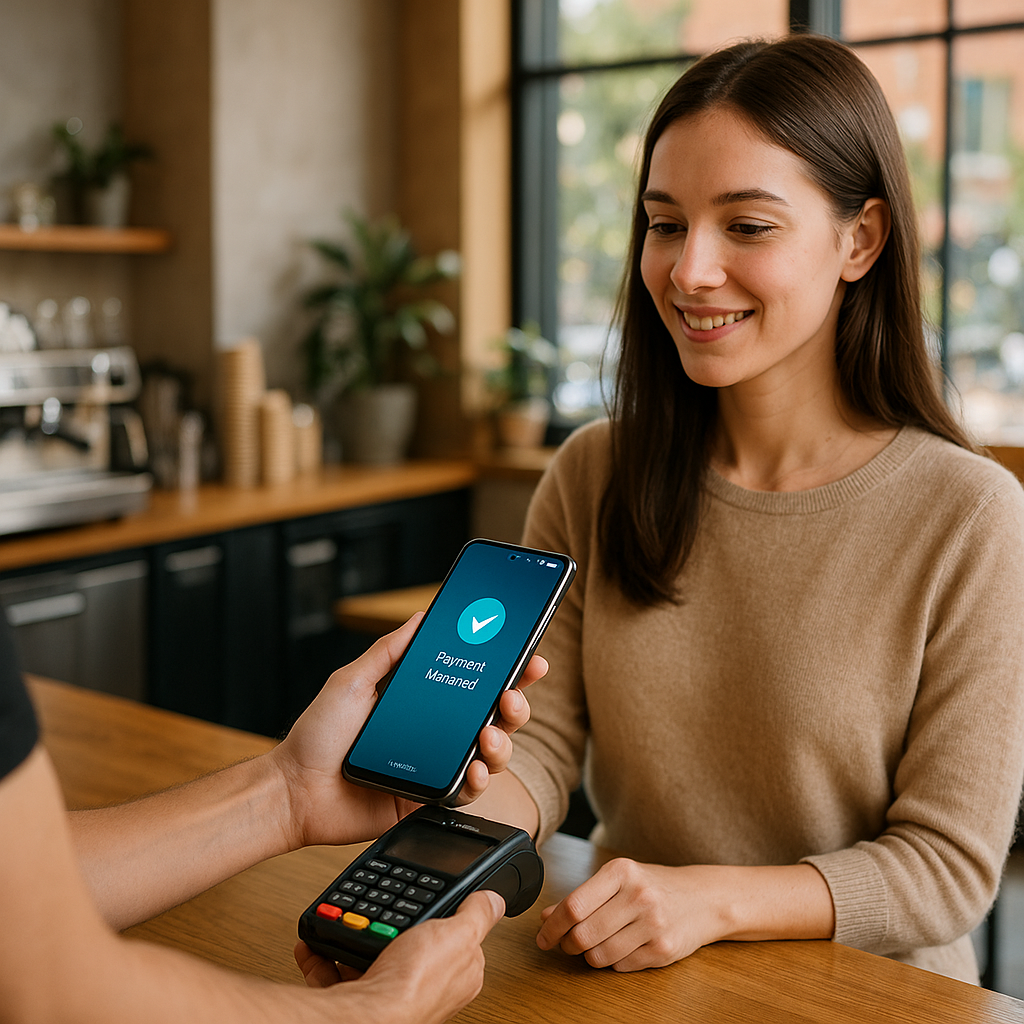

In [25]:
import json
from base64 import b64decode
from io import BytesIO
from PIL import Image
import requests

# 이미지 생성 요청
response = AzureOpenAI(
    api_version=os.getenv("AZURE_OPENAI_IMAGE_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_IMAGE_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_IMAGE_API_KEY"),
).images.generate(
    model=os.getenv("AZURE_OPENAI_IMAGE_DEPLOYMENT_NAME"),
    prompt=str(
        "현대적인 카페 계산대에서 젊은 여성이 삼성갤럭시 핸드폰 결제하는 모습을 그려줘."
        "스마트폰 화면에는 디지털 지갑 앱의 결제 성공 메시지가 표시되어 있고,"
        "자연광이 들어오는 따뜻한 분위기의 사실적인 고화질 사진으로 그려줘."
        "팔이 이상하게 되지 않게 해줘."
    ),
    n=1,
    size="1024x1024",
    quality="high",
    output_compression=100,
    output_format="png",
)

# 응답에서 이미지 데이터 추출
response = json.loads(response.model_dump_json())
for item in response["data"]:
    if item.get("url"):
        content = requests.get(item["url"]).content
        with open("gpt-image-1.png", "wb") as file:
            file.write(content)
    elif item.get("b64_json"):
        Image.open(BytesIO(b64decode(item["b64_json"]))).save("gpt-image-1.png")
image = Image.open("gpt-image-1.png")

# 저장된 이미지 출력
from IPython.display import Image, display
display(Image(filename="gpt-image-1.png"))

## Video Generation

In [42]:
import requests
import time
import os

# video 생성 요청
response = requests.post(
    f"{os.getenv('AZURE_OPENAI_GPT5_ENDPOINT')}/openai/v1/video/generations/jobs?api-version=preview",
    headers={
        "api-key": os.getenv('AZURE_OPENAI_GPT5_API_KEY'),
        "Content-Type": "application/json"
    },
    json={
        "prompt": (
            '삼성 갤럭시 최신 스마트폰의 시네마틱 광고 영상.'
            '세련된 메탈릭 디자인이 극적인 스튜디오 조명 아래 빛나고, 카메라는 곡선 엣지를 따라 천천히 팬하며 8K 울트라 리얼 디테일을 보여준다.'
            '이어서, 활기찬 도시에 있는 젊은 직장인이 야경을 촬영하는 장면 — 네온 불빛이 갤럭시 화면에 선명하게 반사된다.'
            '다음 장면에서는 학생이 갤럭시로 그림을 그리고, 생생한 AMOLED 디스플레이가 풍부한 색감을 뿜어낸다.'
            '그 후 여행자가 장엄한 산 정상의 일출을 8K 울트라 부드러운 영상으로 기록하는 장면, 드론 같은 스위핑 샷으로 연출된다.'
            '마지막으로 갤럭시 로고를 클로즈업 슬로우 모션으로 보여주며, 태그라인이 빛나듯 나타난다:'
            '“Galaxy – 미래를 당신의 손에.”'
            '스타일: 시네마틱, 세련됨, 현대적, 에너지 넘침, 프리미엄 광고.'
            '카메라: 부드러운 트래킹 샷, 슬로우 모션 클로즈업, 극적인 조명 전환.'
            '화면 비율: 16:9, 8K 울트라 리얼리즘.'
            '영상에 나오는 글자들이 오타가 나지 않게 신경써줘.'
        ),
        "width": 480,
        "height": 480,
        "n_seconds": 5,
        "model": "sora"
    },
)
if not response.ok:
    response.raise_for_status()

# 작업 상태 확인
job_id = response.json()["id"]
status=None
while status not in ("succeeded", "failed", "cancelled"):
    time.sleep(5)  # Wait before polling again
    response = requests.get(
        f"{os.getenv('AZURE_OPENAI_GPT5_ENDPOINT')}/openai/v1/video/generations/jobs/{job_id}?api-version=preview",
        headers={
            "api-key": os.getenv('AZURE_OPENAI_GPT5_API_KEY'),
            "Content-Type": "application/json"
        },
    ).json()
    status = response.get("status")
    print(f"Job status: {status}")

# 생성된 비디오 가져오기
if status == "succeeded":
    if generations := response.get("generations", []):
        generation_id = generations[0].get("id")
        response = requests.get(
            f"{os.getenv('AZURE_OPENAI_GPT5_ENDPOINT')}/openai/v1/video/generations/{generation_id}/content/video?api-version=preview",
            headers={
                "api-key": os.getenv('AZURE_OPENAI_GPT5_API_KEY'),
                "Content-Type": "application/json"
            },
        )
        if response.ok:
            with open("sora.mp4", "wb") as file:
                file.write(response.content)
                print("Completed video generation")
    else:
        raise Exception("No generations found in job result.")
else:
    raise Exception(f"Job didn't succeed. Status: {status}")

Job status: preprocessing
Job status: preprocessing
Job status: running
Job status: processing
Job status: processing
Job status: processing
Job status: succeeded
Completed video generation


## Realtime Speech and Audio

In [27]:
import base64
import numpy as np
import sounddevice as sd
from openai import AsyncAzureOpenAI
from openai.types.beta.realtime import ConversationItemParam, ConversationItemContentParam

# 오디오 출력 설정 (PCM16, mono, 24kHz)
stream = sd.OutputStream(
    channels=1,
    samplerate=24000,
    dtype=np.int16,
)
stream.start()

# 실시간 음성 및 오디오 연결 예제
async with AsyncAzureOpenAI(
    api_version="2025-04-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_GPT5_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_GPT5_API_KEY"),
).beta.realtime.connect(
    model="gpt-4o-mini-realtime-preview",
) as connection:
    # 오디오 출력 포맷/보이스 지정 (PCM16 권장)
    await connection.session.update(session={
        "modalities": ["text", "audio"],
        "voice": "alloy",              # 지원 보이스 중 하나
        "audio_format": "pcm16",       # 출력 포맷: 16-bit PCM
        "audio_sample_rate_hz": 24000,  # 샘플레이트 명시(지원 시)
    })
    
    await connection.session.update(session={"modalities": ["text", "audio"]})  
    while True:
        user_input = input("Enter a message: ")
        if user_input == "q":
            break

        await connection.conversation.item.create(
            item=ConversationItemParam(
                type="message",
                role="user",
                content=[ConversationItemContentParam(type="input_text", text=user_input)],
            )
        )
        await connection.response.create()
        async for event in connection:
            if event.type == "response.text.delta":
                print(event.delta, flush=True, end="")
            elif event.type == "response.audio.delta":
                print(f"Received audio data.")
                # base64 → PCM16 bytes
                audio_bytes = base64.b64decode(event.delta)
                if audio_bytes:
                    pcm = np.frombuffer(audio_bytes, dtype=np.int16)
                    stream.write(pcm)  # 스피커로 즉시 출력
            elif event.type == "response.audio_transcript.delta":
                print(f"Received text delta: {event.delta}")
            elif event.type == "response.text.done":
                print()
            elif event.type == "response.done":
                break
            
stream.stop()
stream.close()

Received text delta: If
Received text delta:  you
Received text delta:  need
Received text delta:  anything
Received text delta:  else
Received text delta: ,
Received audio data.
Received audio data.
Received text delta:  just
Received audio data.
Received text delta:  let
Received text delta:  me
Received text delta:  know
Received text delta: .
Received audio data.
Received audio data.
Received text delta:  Take
Received text delta:  care
Received text delta: !
Received audio data.
Received audio data.
Received audio data.


In [28]:
from base64 import b64decode

# 오디오 생성 요청
completion = AzureOpenAI(
    api_version=os.getenv("AZURE_OPENAI_GPT5_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_GPT5_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_GPT5_API_KEY"),
).chat.completions.create(
    model="gpt-4o-audio-preview",
    modalities=["text", "audio"],
    audio={"voice": "alloy", "format": "wav"},
    messages=[
        {
            "role": "user",
            "content": "오늘 기분이 좋아. 노래 불러줘."
        }
    ]
)

# 오디오 데이터 추출 및 저장
wav_bytes = b64decode(completion.choices[0].message.audio.data)
with open("gpt-4o-audio-preview.wav", "wb") as f:
    f.write(wav_bytes)

/opt/anaconda3/envs/azure-dev/lib/python3.12/site-packages/opentelemetry/sdk/_events/__init__.py:53: LogDeprecatedInitWarning: LogRecord init with `trace_id`, `span_id`, and/or `trace_flags` is deprecated since 1.35.0. Use `context` instead.
  log_record = LogRecord(


# Tools

## File Vectors and Code Interpreter

In [30]:
file = client.files.create(
    file=open("resources/KB주택시장리뷰_2025년 8월호.pdf", "rb"),
    purpose="assistants",
)
file.id

'assistant-Pf1tZNSc3niYNMgUbLHsMN'

In [33]:
response = client.responses.create(
    model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    tools=[{
        "type": "code_interpreter",
        "container": {"type": "auto", "file_ids": [file.id]},
    }],
    tool_choice="required",
    input="PDF 의 5번째 페이지 본문에 있는 그림들을 추출해서 하나의 파일로 압축해서 응답해줘.",
)

# response 에서 container 에 추가된 file 다운로드
for output in response.output:
    if output.type == "message":
        for content in output.content:
            if content.type == "output_text":
                for annotation in content.annotations:
                    if annotation.type == "container_file_citation":
                        """
                        {
                            "container_id": "cntr_68ad102ea8e881909a32e6dd72248e410c9b8c023398d21b",
                            "end_index": 164,
                            "file_id": "cfile_68ad1034246c8190a8c43a410c50fcc0",
                            "filename": "extracted_images.zip",
                            "start_index": 126,
                            "type": "container_file_citation"
                        }
                        """
                        response = client.containers.files.content.with_raw_response.retrieve(
                            container_id=annotation.container_id,
                            file_id=annotation.file_id,
                        )
                        with open(annotation.filename, "wb") as f:
                            f.write(response.content)
                        print("saved: {}".format(annotation.filename))

saved: page5_images.zip


## MCP (STDIO)

In [37]:
# export ACCUWEATHER_API_KEY=II3dLRMviCfziKA6dVzQ17IkO6Rh22jQ
# npx -y @timlukahorstmann/mcp-weather
# pip install 
import asyncio, json
from mcp import ClientSession
from mcp.client.stdio import stdio_client, StdioServerParameters

params = StdioServerParameters(
    command="npx",
    args=["-y", "@timlukahorstmann/mcp-weather"],
    env={"ACCUWEATHER_API_KEY": "II3dLRMviCfziKA6dVzQ17IkO6Rh22jQ"},
)
async with stdio_client(params) as (read, write):
    async with ClientSession(read, write) as session:
        tools = await session.list_tools()
        available_tools = [{
            "type": "function",
            "function": {
                "name": tool.name,
                "description": tool.description,
                "parameters": tool.inputSchema,
            }
        } for tool in tools.tools]
        
        # Start conversational loop
        messages = []
        while True:
            try:
                user_input = input("\nPrompt: ")
                if not user_input or user_input.lower() == "exit":
                    break
                messages.append({"role": "user", "content": user_input})

                # First API call with tool configuration
                response = client.chat.completions.create(
                    model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
                    messages=messages,
                    tools=available_tools,
                )

                # Process the model's response
                response_message = response.choices[0].message
                messages.append(response_message)

                # Handle function calls
                if response_message.tool_calls:
                    for tool_call in response_message.tool_calls:
                            #print(f"🤖 tool_call: {tool_call.function.name}")
                            function_args = json.loads(tool_call.function.arguments)
                            result = await session.call_tool(tool_call.function.name, function_args)

                            # Add the tool response to the messages
                            messages.append({
                                "tool_call_id": tool_call.id,
                                "role": "tool",
                                "name": tool_call.function.name,
                                "content": result.content,
                            })
                else:
                    print("No tool calls were made by the model")

                # Get the final response from the model
                final_response = client.chat.completions.create(
                    model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
                    messages=messages,
                    tools=available_tools,
                )

                print(f"👱🏻 {user_input}")
                for item in final_response.choices:
                    print(f"🤖 {item.message.content}")
            except Exception as e:
                print(f"Error in conversation loop: {e}")
                print(f"An error occurred: {e}")

/opt/anaconda3/envs/azure-dev/lib/python3.12/site-packages/opentelemetry/sdk/_events/__init__.py:53: LogDeprecatedInitWarning: LogRecord init with `trace_id`, `span_id`, and/or `trace_flags` is deprecated since 1.35.0. Use `context` instead.
  log_record = LogRecord(


👱🏻 오늘 아시아 주요 도시들의 날씨를 말해줘. 도시부터 나열하고, tools 을 이용해서 도시별로 조사해줘.
🤖 아시아 주요 도시들의 오늘(2025년 8월 27일) 날씨는 다음과 같습니다:

1. 서울 (대한민국)
   - 최저 22.8°C ~ 최고 32.4°C
   - 낮: 대체로 흐림 / 밤: 부분적으로 흐림

2. 도쿄 (일본)
   - 최저 26.2°C ~ 최고 35.2°C
   - 낮: 매우 덥고 / 밤: 천둥번개, 강수 예상

3. 베이징 (중국)
   - 최저 18.7°C ~ 최고 22.5°C
   - 낮: 소나기 / 밤: 천둥번개, 강수 예상

4. 방콕 (태국)
   - 최저 25.4°C ~ 최고 32°C
   - 낮: 비 / 밤: 소나기, 강수 예상

5. 싱가포르 (싱가포르)
   - 최저 25.9°C ~ 최고 31.7°C
   - 낮: 대체로 흐림 / 밤: 대체로 맑음

6. 델리 (인도)
   - 최저 26.3°C ~ 최고 33.1°C
   - 낮: 부분적으로 맑고 소나기 / 밤: 대체로 흐림, 천둥번개 및 강수 예상

7. 두바이 (아랍에미리트)
   - 최저 32.8°C ~ 최고 44.9°C
   - 낮: 매우 덥고 / 밤: 맑음

궁금한 도시가 더 있다면 추가로 알려드릴 수 있습니다!


In [38]:
available_tools

[{'type': 'function',
  'function': {'name': 'weather-get_hourly',
   'description': 'Get hourly weather forecast for the next 12 hours',
   'parameters': {'type': 'object',
    'properties': {'location': {'type': 'string',
      'description': 'The city or location for which to retrieve the weather forecast.'},
     'units': {'type': 'string',
      'description': 'Temperature unit system (metric for Celsius, imperial for Fahrenheit). Default is metric.',
      'enum': ['metric', 'imperial']}},
    'required': ['location']}}},
 {'type': 'function',
  'function': {'name': 'weather-get_daily',
   'description': 'Get daily weather forecast for up to 15 days',
   'parameters': {'type': 'object',
    'properties': {'location': {'type': 'string',
      'description': 'The city or location for which to retrieve the weather forecast.'},
     'days': {'type': 'number',
      'description': 'Number of days to forecast (1, 5, 10, or 15). Default is 5.',
      'enum': [1, 5, 10, 15]},
     'units